# Clippers

Waveshaping is at the heart of musical filters. Moog's transistor ladder wouldn't sound good if it weren't for the saturation the transistors themselves provide (and in fact, it wouldn't work at all!). So designing waveshapers to put in the various stages of filters is going to greatly affect the sound of it.

Why not just stick a $tanh$ and be done with it? $tanh$, while a good approximation (and good first guess for the Newton-Rhapson evaluations later), mostly fails at being a good emulation of a clipping element. $tanh$'s output domain is $[-1,1]$, whereas diodes and transistors can theoretically output any voltage (only limited by how much current they can handle before blowing out). Musically this translates to $tanh$ sounding too harsh and choking resonances faster than a physically equivalent circuit. Diode clippers, for example, exhibit a waveshaping that's halfway between digital hard-clipping and a $log$-based clipping function, and as such the sound of it also appears halfway through.

Perhaps famously, the waveshaping of analog clippers does not result in an analytical function that can be easily modeled and used in the signal path. Instead, we have to resort to implicit equation solving, and thus use the widely used Newton-Rhapson method to evaluate them.

The implementation will consist of modeling the transfer curve with an analytic equation.

## Diode clippers

The diode clipper is one of the most basic musical circuits, being used everywhere from overdrive and fuzz pedals to taming the resonance in the feedback path of filters. We also model a small load impedence, as such:

<center>
    <img src="./diode-clipper.svg" width="400px"/>
</center>

We'll model the diodes using the Shockely equation:
$$ I_\text{DIODE}\left(V_\text{DIODE}\right) = I_s \left(\exp\left(\frac{V_\text{DIODE}}{nV_T}\right) - 1\right) $$

The circuit equation is:
$$ V_\text{IN} = 2 V_\text{OUT} + R\left( I_D\left(\frac{V_\text{OUT}}{N}\right)-I_D\left(-\frac{V_\text{OUT}}{M}\right) \right) $$

Where $N$ is the number of diodes in the forward direction, and $M$ is the number in the backwards direction (in the schematics, $N=M=1$).

In [2]:
from sympy import *


diode_expr = lambda isat, n, vt: lambda v: isat*(exp(v/(n*vt))-1)

def diode_eq(vin, vout, r, id, n=1, m=1):
    return Eq(vin, 2*vout + r*(id(vout/n)-id(-vout/m)))

diode_eq(*symbols('v_in v_out', real=True), 1, diode_expr(*symbols('i_sat n v_T', real=True, positive=True)), *symbols('N M')).simplify()

Eq(v_in, i_sat*exp(v_out/(N*n*v_T)) - i_sat*exp(-v_out/(M*n*v_T)) + 2*v_out)

In [3]:
vin, vout = symbols('v_in v_out', real=True)
diff(diode_eq(vin, vout, Symbol('R', real=True, positive=True), diode_expr(*symbols('i_sat n v_T', real=True, positive=True)), *symbols('N M', integer=True, positive=True)).rhs, vout)


R*(i_sat*exp(v_out/(N*n*v_T))/(N*n*v_T) + i_sat*exp(-v_out/(M*n*v_T))/(M*n*v_T)) + 2

We can solve this implicit equation with Newton-Rhapson, and plot the DC bias transfer:

In [4]:
from dataclasses import dataclass, field as dfield
from itertools import repeat
from functools import lru_cache
from typing import Callable, NamedTuple, TypeAlias
import numpy as np


@dataclass(frozen=True, unsafe_hash=True)
class DiodeClipperConfiguration:
    isat: float
    n: float
    vt: float
    nf: int
    nb: int

    @classmethod
    def silicon(cls, nf: int = 1, nb: int = 1, vt: float = 23e-3) -> "DiodeClipperConfiguration":
        return cls(isat=4.352e-9, n=1.906, vt=vt, nf=nf, nb=nb)

    @classmethod
    def germanium(cls, nf: int = 1, nb: int = 1, vt: float = 23e-3) -> "DiodeClipperConfiguration":
        return cls(isat=200e-9, n=2.109, vt=vt, nf=nf, nb=nb)

    @classmethod
    def led(cls, nf: int = 1, nb: int = 1, vt: float = 23e-3) -> "DiodeClipperConfiguration":
        return cls(isat=2.96406e-12, n=2.475312, vt=vt, nf=nf, nb=nb)

    def get_nr_model(self, maxiter=0, tol=1e-6) -> "NewtonRhapson":
        vin, vout = symbols('v_in v_out', real=True)
        return NRSymbolic(vin, vout, diode_eq(vin, vout, 1, diode_expr(self.isat, self.n, self.vt), self.nf, self.nb), n=maxiter, tol=tol)

arr: TypeAlias = np.ndarray[tuple[int], np.dtype[np.float32]]

RootEqu: TypeAlias = Callable[[arr, arr], arr]

@dataclass
class NewtonRhapson:
    """Implementation of the Newton-Rhapson method.
    Resolution is done by iterating up to n times, or when the step modifies the guess
    by less than `tol` RMS."""

    eval: RootEqu
    diff: RootEqu
    n: int = 0
    tol: float = 1e-6
    iter: list[arr] = dfield(default_factory=list)

    def __call__(self, x: arr, initial:arr|None=None) -> arr:
        """Evaluate the implicit equation at x, with the initial solution provided (default: 0)."""
        if initial is None:
            initial = np.zeros_like(x)
        guess=np.copy(initial)
        self.iter = []
        it = range(self.n) if self.n > 0 else repeat(0)
        for _ in it:
            dy = self.diff(x, guess)
            if rms(dy) < self.tol:
                break
            step = self.eval(x,guess) / dy
            srms = rms(step)
            if srms < self.tol:
                break
            # tqdm.write(f"{i:3}: {db(srms):2.3} dB RMS")
            guess -= step
            self.iter.append(np.copy(guess))
        # print(f"guessed within {db(srms)} dB")
        return guess


class NRSymbolic(NewtonRhapson):
    """Implementation of the Newton-Rhapson method over a symbolic SymPy expression.
    Resolution is done by iterating up to n times, or when the step modifies the guess
    by less than `tol` RMS."""
    def __init__(self, x: Symbol, y: Symbol, expr: Expr|Eq, *args, **kwargs):
        if isinstance(expr, Eq):
            expr = expr.rhs - expr.lhs
        super().__init__(lambdify([x,y], expr, 'scipy'), lambdify([x,y], diff(expr, y), 'scipy'), *args, **kwargs)


def rms(x: arr) -> float:
    return np.sqrt(np.sum(x**2)/len(x))


def db(x: float) -> float:
    return 20 * np.log10(x)


def rmsdb(x: arr) -> float:
    return db(rms(x))

class EvalOutput(NamedTuple):
    x: arr
    y: arr

@lru_cache()
def evaluate_diode_eq(config: DiodeClipperConfiguration = DiodeClipperConfiguration.silicon(), range=12, step=0.01) -> EvalOutput:
    nr = config.get_nr_model()
    x = np.arange(-range, range+step, step)
    y = nr(x, initial=np.tanh(x))

    return EvalOutput(x, y)

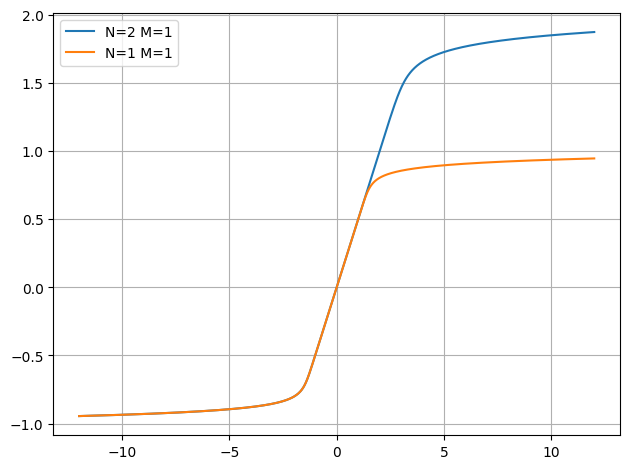

In [5]:
import matplotlib.pyplot as plt


x, y = evaluate_diode_eq(DiodeClipperConfiguration.silicon(2, 1))
plt.plot(x, y, label="N=2 M=1")

x, y = evaluate_diode_eq()
plt.plot(x, y, label="N=1 M=1")

plt.grid(True, 'both')
plt.tight_layout()
plt.legend()

Let's now try to fit $tanh$ into the above, and compute the error:

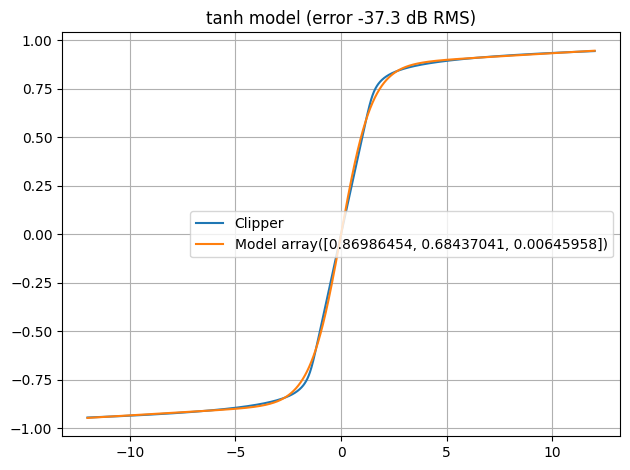

In [6]:
from scipy.optimize import curve_fit

def sat(x, a, b, c):
    return a*np.tanh(b*x) + c*x

x, y = evaluate_diode_eq()
v, _ = curve_fit(sat, x, y)
ymodel = sat(x, *v)

plt.plot(x, y, label="Clipper")
plt.plot(x, ymodel, label=f"Model {v!r}")
plt.title(f"tanh model (error {rmsdb(ymodel-y):2.3} dB RMS)")
plt.grid(True, 'both')
plt.tight_layout()
plt.legend()

Alright in the single diode case, let's try with 3:

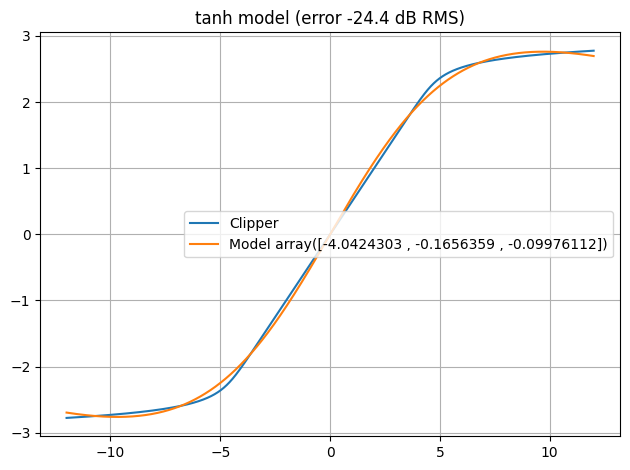

In [7]:
from scipy.optimize import curve_fit

x, y = evaluate_diode_eq(DiodeClipperConfiguration.silicon(3, 3))
v, _ = curve_fit(sat, x, y)
ymodel = sat(x, *v)

plt.plot(x, y, label="Clipper")
plt.plot(x, ymodel, label=f"Model {v!r}")
plt.title(f"tanh model (error {rmsdb(ymodel-y):2.3} dB RMS)")
plt.grid(True, 'both')
plt.tight_layout()
plt.legend()

$tanh$ can't really keep up here, and it's easy to intuitively reject it as a good model for an assymetric $\left(N \neq M\right)$ clipper. We need to amend it.

Graphically, we can recognize the diode bias curve has 3 components: the linear component across the zero, the positive wave saturation and the negative wave saturation.

The saturation comes from the current into the diodes being limited by the Shockely equation - intuitively, the saturation has a curve following the inverse of $e^x$, which is $\ln x$.

Therefore, we can set up a parametrized saturator as a piecewise function:

In [8]:
a, b, si, so = symbols('a b S_I S_O', real=True, positive=True)
x = si*Symbol('x', real=True)
sat_sym = lambda x: so * Piecewise(
    (-log(1-x-a) - a, x < a),
    (log(1+x-b) + b, x > b),
    (x, True)
)
sat_sym(x)

S_O*Piecewise((-a - log(-S_I*x - a + 1), a > S_I*x), (b + log(S_I*x - b + 1), b < S_I*x), (S_I*x, True))

C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:3: RuntimeWarning: divide by zero encountered in log
  lower = -np.log(1-x-a) - a
C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:3: RuntimeWarning: invalid value encountered in log
  lower = -np.log(1-x-a) - a
C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:4: RuntimeWarning: divide by zero encountered in log
  higher = np.log(1+x-b) + b
C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:4: RuntimeWarning: invalid value encountered in log
  higher = np.log(1+x-b) + b


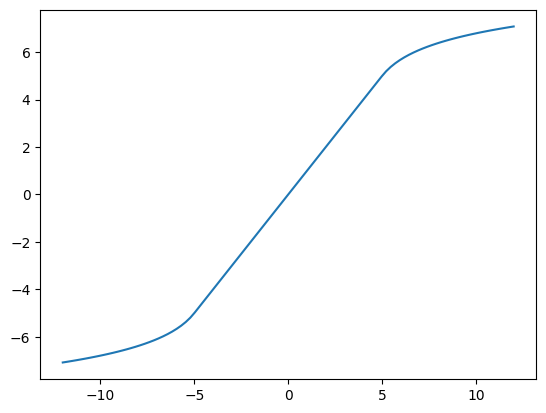

In [9]:
def sat(x, a, b, si, so):
    x = si*x
    lower = -np.log(1-x-a) - a
    higher = np.log(1+x-b) + b
    sat = np.where(x > -a, np.where(x > b, higher, x), lower)
    return so*sat

x = np.linspace(-12, 12, 100)
y = sat(x, 5, 5, 1, 1)
plt.plot(x, y)

We can now model our diode clipper by fitting the parameters for various configurations, starting with a classic 1+1 silicon diode configuration:

C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:3: RuntimeWarning: invalid value encountered in log
  lower = -np.log(1-x-a) - a
C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:4: RuntimeWarning: invalid value encountered in log
  higher = np.log(1+x-b) + b


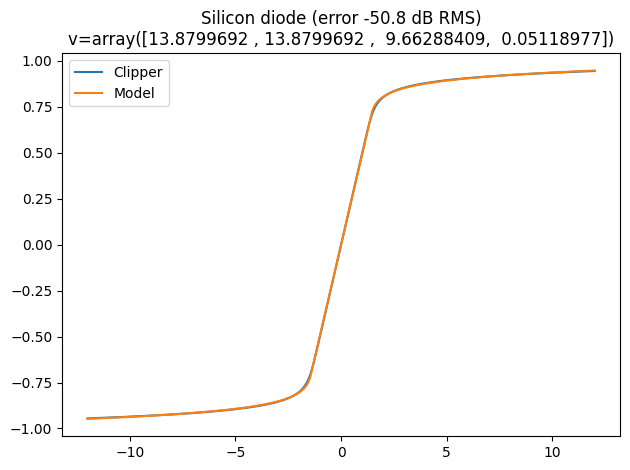

In [10]:
x, y = evaluate_diode_eq()
v, _ = curve_fit(sat, x, y, bounds=([0,0, -np.inf, -np.inf],[np.inf, np.inf, np.inf, np.inf]))
ysat = sat(x, *v)

plt.title(f"Silicon diode (error {rmsdb(y-ysat):2.3} dB RMS)\n{v=!r}")
plt.plot(x, y, label="Clipper")
plt.plot(x, ysat, label=f"Model")
plt.tight_layout()
plt.legend()

In [11]:
from dataclasses import dataclass
from itertools import product
from typing import Generic, Optional, ParamSpec, Protocol, TypeVar

from scipy import optimize as opt

_T = TypeVar("_T", bound=tuple[arr, ...])

class Curve(Generic[_T], Protocol):
    num_parameters: int

    def eval(self, x: arr, *parameters: _T) -> arr:
        ...

    def diff(self, x: arr, *parameters: _T) -> arr:
        ...


@dataclass
class CurveFit(Generic[_T]):
    curve: Curve[_T]
    initial_guess: Optional[_T] = None
    minima: list[arr] = dfield(default_factory=list)

    def fit(self, x: arr) -> _T:
        if (initial_guess := self.initial_guess) is None:
            initial_guess = np.random.random(self.curve.num_parameters)

        bound = (0, 100)
        bounds = (
            (0.01, 20),
            (0.01, 20),
            (0.01, 100),
            (0.01, 100),
        )
        # result = opt.differential_evolution(lambda args: np.linalg.norm(self.curve.diff(x, *args)), bounds=bounds)
        result = opt.shgo(lambda args: np.linalg.norm(self.curve.diff(x, *args), ord=np.inf), bounds)
        assert result.success, result.message
        return result.x


@dataclass
class DiodeClipperModel(Curve[tuple[arr, arr, arr, arr]]):
    num_parameters = 4
    config: DiodeClipperConfiguration
    diode_nr: NewtonRhapson = dfield(init=False)

    def __post_init__(self):
        self.diode_nr = self.config.get_nr_model()

    def eval(self, x: arr, a: arr, b: arr, si: arr, so: arr) -> arr:
        return sat(x, a, b, si, so)

    def diff(self, x: arr, *parameters: arr) -> arr:
        return self.diode_nr.eval(x, self.eval(x, *parameters))


## === Uncomment to produce the Rust code section used to generate the model values
# for nf,nb in product(range(1, 6), repeat=2):
#     x,y = evaluate_diode_eq(isat=2.96406e-12, n=2.475312, nf=nf, nb=nb, step=1)
#     v, _ = curve_fit(sat, x, y, bounds=([0,0, -np.inf, -np.inf],[np.inf, np.inf, np.inf, np.inf]))
#     print(f"({nf},{nb}) => [{v[0]}, {v[1]}, {v[2]}, {v[3]}],")

C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:3: RuntimeWarning: divide by zero encountered in log
  lower = -np.log(1-x-a) - a
C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:3: RuntimeWarning: invalid value encountered in log
  lower = -np.log(1-x-a) - a
C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:4: RuntimeWarning: divide by zero encountered in log
  higher = np.log(1+x-b) + b
C:\Users\solar\AppData\Local\Temp\ipykernel_5560\493887309.py:4: RuntimeWarning: invalid value encountered in log
  higher = np.log(1+x-b) + b


// RMS error: -54.7 dB
(1,1) => [14.818703633669296,14.818703633541146,10.303204570696694,0.048404774265213925],
// RMS error: -35.1 dB
(1,2) => [22.304806511403722,9.055985923658788,6.927666963557559,0.07081909604048883],
// RMS error: -29.4 dB
(1,3) => [27.83682166632861,6.632634104057635,5.490576255404195,0.08840289037667301],
// RMS error: -26.2 dB
(1,4) => [29.45764524305769,4.5567503249490136,4.354372165627167,0.11255226896931593],
// RMS error: -24.4 dB
(1,5) => [33.57088716701823,3.8077841779405666,3.9253229508761422,0.12514246621927497],
// RMS error: -35.1 dB
(2,1) => [9.055985630091193,22.30480590322051,6.927666800040047,0.0708190977258508],
// RMS error: -45.4 dB
(2,2) => [14.971157352076087,14.971157351972952,4.935272490385709,0.09960226412923741],
// RMS error: -34.6 dB
(2,3) => [17.973630352246342,10.787672828377609,3.796833960006928,0.1301342984492022],
// RMS error: -29.9 dB
(2,4) => [21.1260322620653,8.85153502088645,3.2491921551375893,0.15204639135544615],
// RMS err

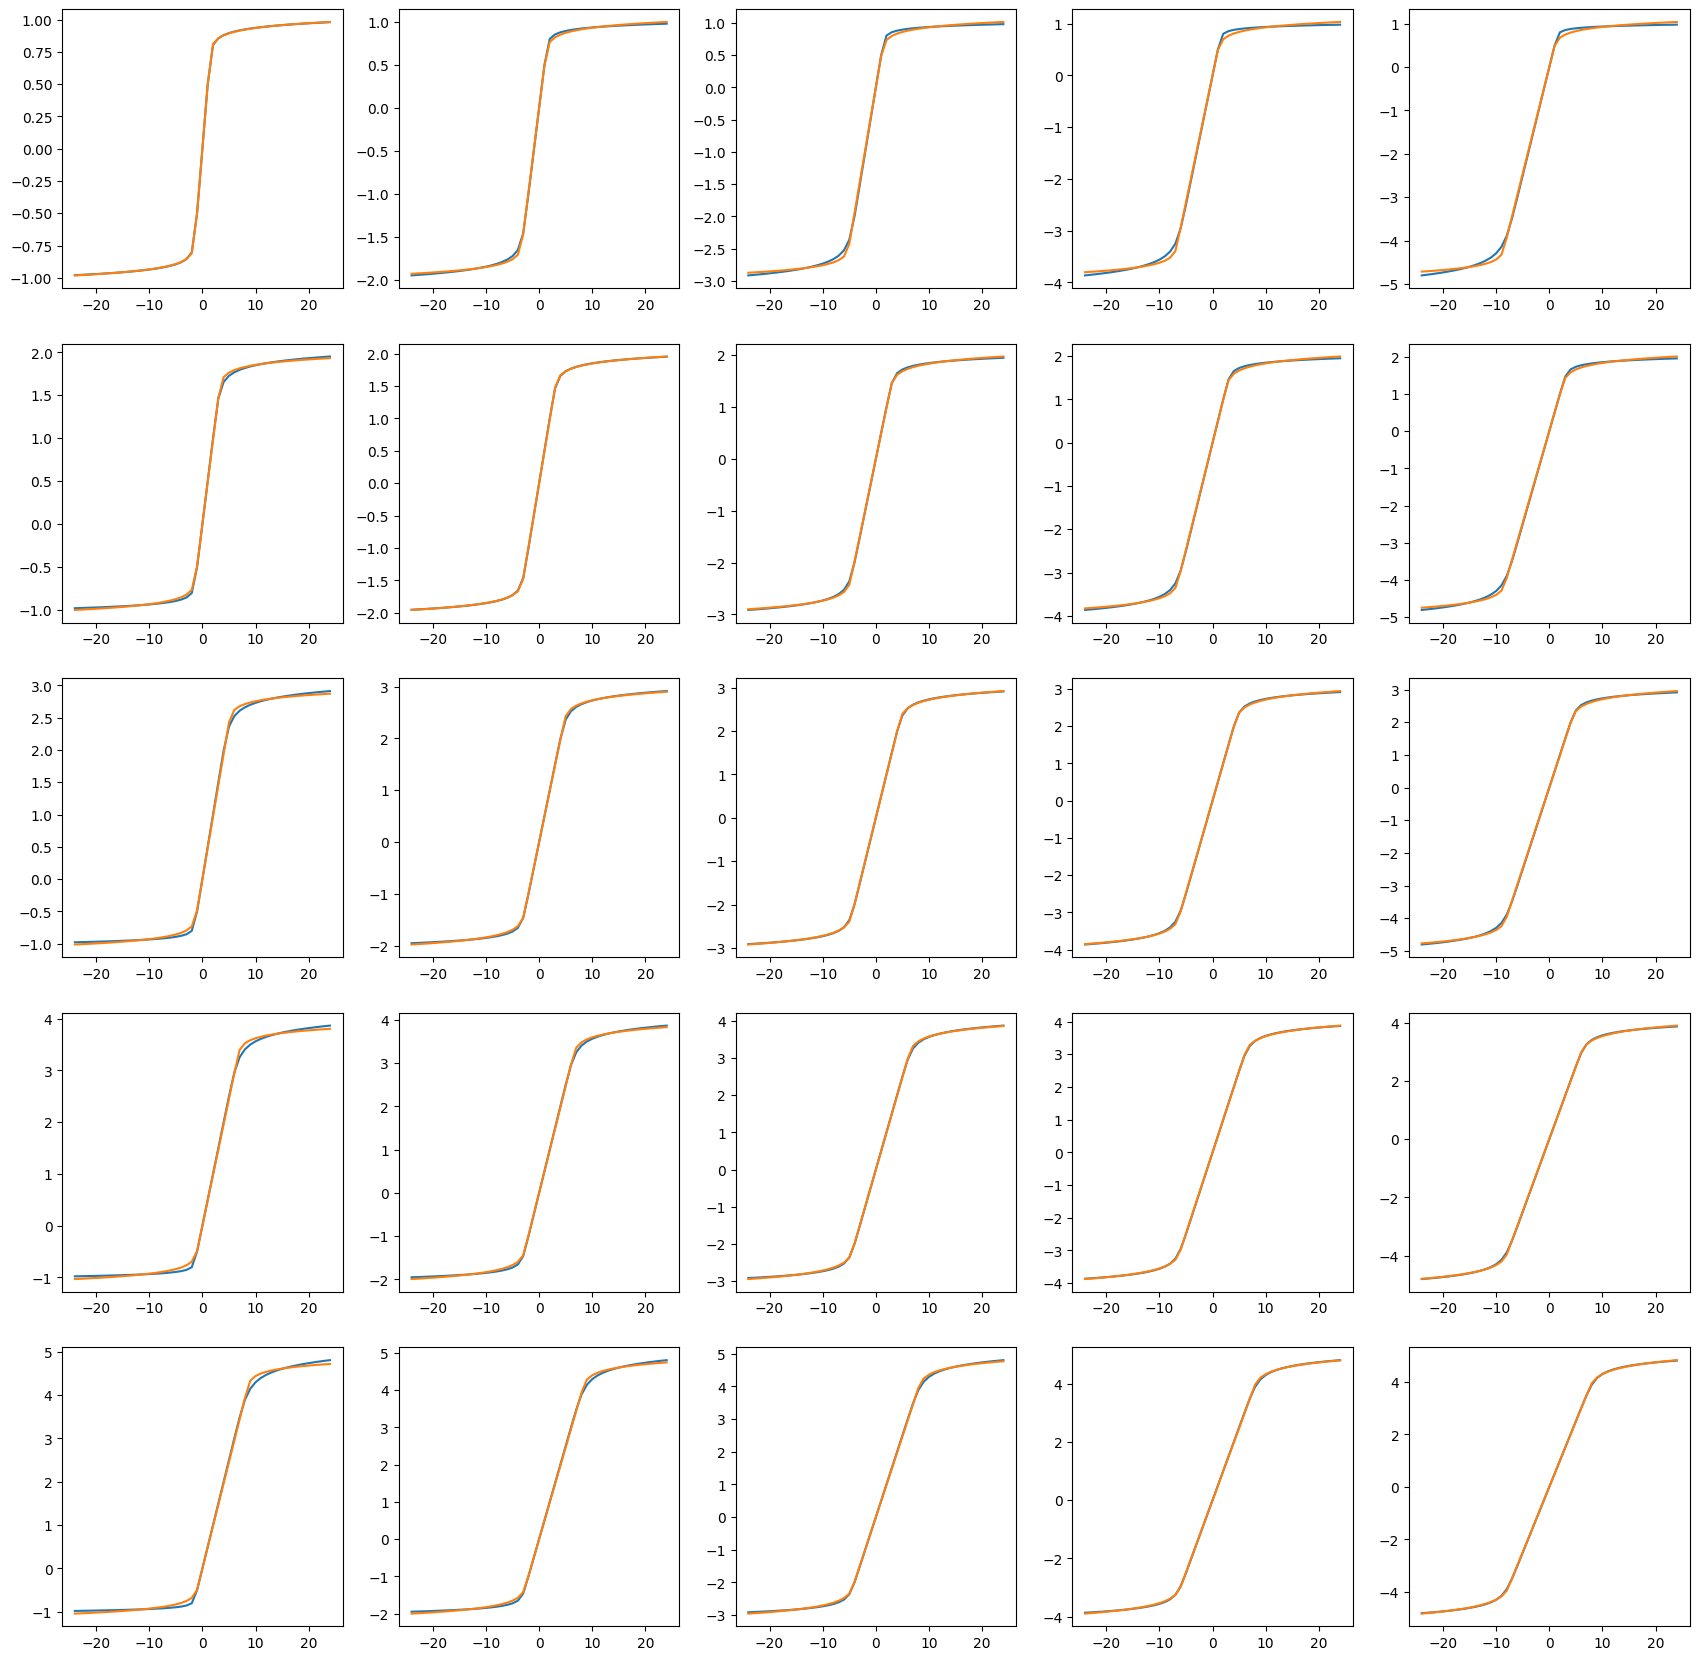

In [28]:
fig, axs = plt.subplots(5, 5, figsize=(21,21))
for i,j in product(range(5), repeat=2):
    ax = axs[i,j]
    nf = i+1
    nb = j+1
    config = DiodeClipperConfiguration.silicon(nf, nb)
    x, y = evaluate_diode_eq(config, range=24, step=1)
    params, _ = curve_fit(sat, x, y)
    ymodel = sat(x, *params)
    err = rmsdb(y-ymodel)
    params_repr = ','.join(map(str, params)) 
    print(f"// RMS error: {err:2.3} dB", f"({nf},{nb}) => [{params_repr}],", sep="\n")
    ax.plot(x, y)
    ax.plot(x, ymodel)
    # ax.set_title(f"{nf=} {nb=}")

We can fit for typical Germanium diode parameters:

In [128]:
x, y = evaluate_diode_eq(200e-12, 2.109)
v, _ = curve_fit(sat, x, y, bounds=([0,0, -np.inf, -np.inf],[np.inf, np.inf, np.inf, np.inf]))
ysat = sat(x, *v)

plt.title(f"Germanium diode (error {rmsdb(y-ysat):2.3} dB RMS)\n{v=!r}")
plt.plot(x, y, label="Clipper")
plt.plot(x, ysat, label=f"Model")
plt.tight_layout()
plt.legend()

AttributeError: 'float' object has no attribute 'get_nr_model'

Assymetrical Germanium setup:

/tmp/ipykernel_601181/493887309.py:3: RuntimeWarning: invalid value encountered in log
  lower = -np.log(1-x-a) - a
/tmp/ipykernel_601181/493887309.py:4: RuntimeWarning: invalid value encountered in log
  higher = np.log(1+x-b) + b


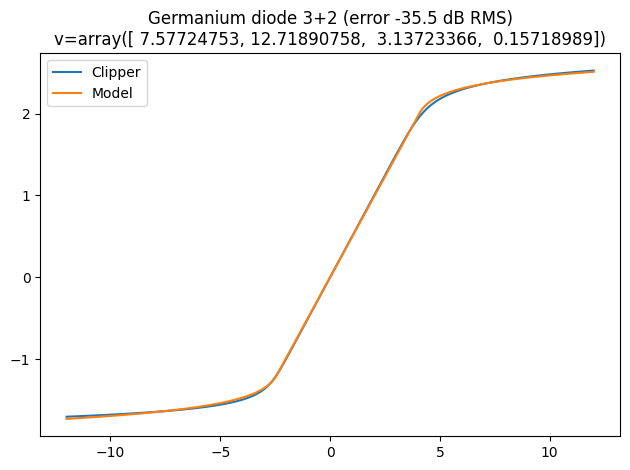

In [ ]:
x, y = evaluate_diode_eq(200e-9, 2.109, nf=3, nb=2)
v, _ = curve_fit(sat, x, y, bounds=([0,0, -np.inf, -np.inf],[np.inf, np.inf, np.inf, np.inf]))
ysat = sat(x, *v)

plt.title(f"Germanium diode 3+2 (error {rmsdb(y-ysat):2.3} dB RMS)\n{v=!r}")
plt.plot(x, y, label="Clipper")
plt.plot(x, ysat, label=f"Model")
plt.tight_layout()
plt.legend()


## Alternative implementation: Lookup table + Newton-Rhapson refinement

It is also possible, as an alternative implementation, to precompute the transfer curve with a high iteration count and low tolerance value, and store it in a lookup table with constant time access. The problems come with interpolation of the lookup table, which are going to translate into discontinuities in the output signal, in turn causing the harmonic content to change and diverge from ground truth. To remediate this, it is possible to take the lookup table output, and iterate once with Newton-Rhapson to converge on a higher quality output value.

In fact, solving with a resolution of 1 pt/V (so, 24 points across the $\pm$ 12 V range of a typical supply rail voltage, e.g. eurorack) gives a RMS error of -50 dB, and two steps goes down to -70 dB RMS error.

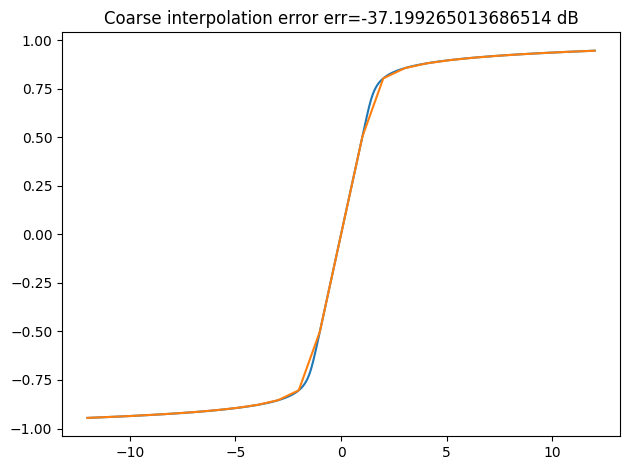

In [ ]:
from scipy.interpolate import interp1d

x, y = evaluate_diode_eq(step=0.01)
xcoarse, ycoarse = evaluate_diode_eq(step=1)
sat_interp = interp1d(xcoarse, ycoarse, 'linear', assume_sorted=True)

err = rmsdb(sat_interp(x)-y)
plt.plot(x, y)
plt.plot(x, sat_interp(x))
plt.title(f"Coarse interpolation error {err=!r} dB")
plt.tight_layout()

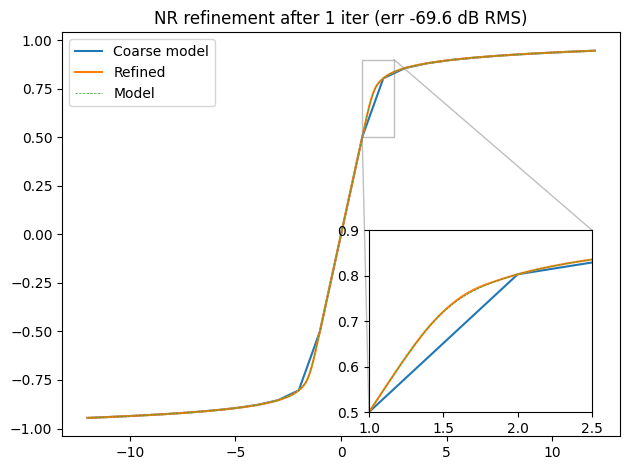

In [ ]:
# diode = lambda isat,n,vt: lambda x,y: isat*(np.exp(-1+y/(n*vt))/(n*vt) - np.exp(-1-y/(n*vt))/(n*vt)) +2*y
# diode_diff = lambda isat,n,vt: lambda x,y: isat*(np.exp(-1+y/(n*vt) + np.exp(-1-y/(n*vt)))) + 2
vin, vout = symbols('v_in v_out', real=True)

yin = sat_interp(x)
# nr = NewtonRhapson(diode(4.352e-9, 1.906, 0.023), diode_diff(4.352e-9, 1.906, 0.023), n=100)
nr = NRSymbolic(vin, vout, diode_eq(vin, vout, 1, diode_expr(4.352e-9, 1.906, 0.023)), n=2)
ynext = nr(x, initial=yin)

fig, ax = plt.subplots()
ax.plot(x, yin, label="Coarse model")
ax.plot(x, ynext, label="Refined")
ax.plot(x, y, '--', label="Model", linewidth=0.5)

axin = ax.inset_axes([0.55, 0.06, 0.4, 0.45])
axin.plot(x, yin, label="Coarse model")
axin.plot(x, ynext, label="Refined")
axin.plot(x, y, '--', label="Model", linewidth=0.5)
axin.set_xlim(1, 2.5)
axin.set_ylim(0.5, 0.9)

ax.indicate_inset_zoom(axin)

plt.title(f"NR refinement after 1 iter (err {rmsdb(ynext-y):2.3} dB RMS)")
plt.tight_layout()
plt.legend(loc='upper left')

## Comparing the methods

The log-model of the diode clipper is a good match for the saturation curve of a diode clipper. It can accomodate multiple diodes in series well, and the average error is quite good that switching from the direct NR implementation to the model is seamless, and qualitatively the two are equivalent. The biggest downside to it, however, is that the log-model is not intuitive to tune, requiring a fit from a previously obtained saturation curve (either through circuit equations and symbolic evaluation like here, or SPICE DC bias simulation, or through real-world measurements). It's not easy to figure out a mapping for the model parameters either, as linear combinations of diode parameters to model parameters don't seem to fit at all.

The Newton-Rhapson benefits from the fact that is has a clear cost-to-quality parameter in the amount of iterations to use. It directly relies on the diodes' Shockley parameters to work, and can be tuned in real time. However this solution is sensitive to the inital guess given, and performance will vary significantly because of it. It also seems 32-bit floats are not enough for pushing the signal loud into the clipper simulation, and breaks down in realtime scenarios, although my independent testing could not confirm it.